## Table of Contents

1. [Module Import](#module-import)
2. [Synthetic Data Generation](#synthetic-data)
3. [Network Construction](#network-construct)
4. [Boundary Condition Assignment](#bc-assign)
4. [Pressure Extraction](#pressure-extract)

***

## Module Import <a class="anchor" id="module-import"></a>

In [1]:
%matplotlib inline

#import libraries we're going to need
import math
import numpy as np
import lagrangiandataprocessing as ldp
import taylorgreenvortex as tgv
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

***

## Synthetic Data Generation <a class="anchor" id="synthetic-data"></a>

Here we define some parameters that will be used in the synthetic data generation.

In [2]:
L = 1 # characteristic length scale, m
rho = 1000 # density, kg/m3
mu = 0.001 # viscosity, Pa*s
V0 = 1 # characteristic velocity, m/s

N = 20000 # number of data points

domain_size = 6 # size of domain in multiples of the charactreristic length

Next, we use the numpy random function and taylor green vortex module to create the synthetic data.
With a lagrangian velocimetry method, we would be able to measure the velocity and acceleration of the particles.

In [3]:
# generate a Nx3 matrix to contain the points
X = L*domain_size*(np.random.rand(N,3)-1/2)

# use the tgv module to retrieve the velocity and acceleration
U = tgv.velocity(X,L,V0)
DUDt = tgv.acceleration(X,L,V0,rho,mu)

# also retrieve the pressure field to compare to the extracted field
pTrue = tgv.pressure(X,L,V0,rho)


Let's visualize the data first in 3D and on a 2D slice on the z=0 plane.

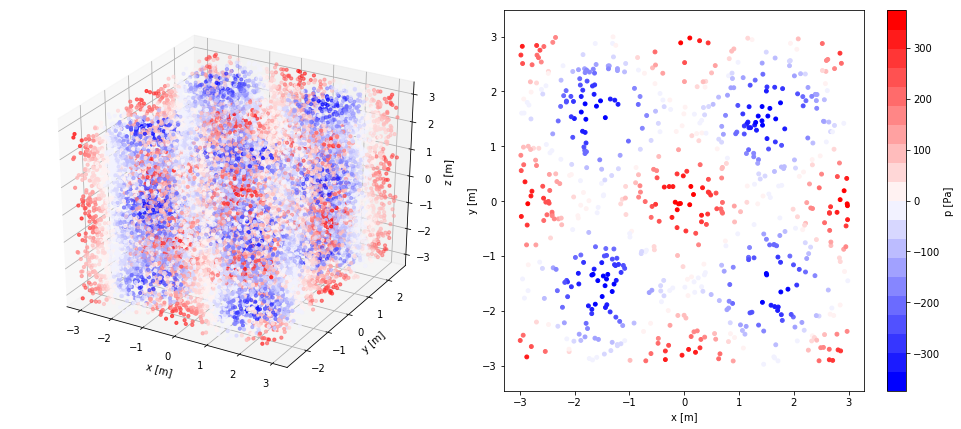

In [4]:
# we want zero to be the middle of the color axis so that white is p=0
# so first find the largest extreme in the pressure data
pMaxAbs = max(np.abs(pTrue))

# then define the limits of the range as the negative and positive of that value
pMax = pMaxAbs
pMin = -pMaxAbs

# we also need to define a threshold for plotting in 2D
# we will plot anything within 0.1m of the z=0 plane
zThresh = 0.1

# set up the colormap
norm = mpl.colors.Normalize(vmin=pMin,vmax=pMax)
cmap=plt.cm.get_cmap('bwr', 20)

# create the figure
fig = plt.figure(figsize=(14,7))

# add a subplot for the 3D plot
ax = fig.add_subplot(121, projection='3d')

ax.scatter(X[:,0],X[:,1],X[:,2],s=10,c=pTrue,cmap=cmap,vmin=pMin, vmax=pMax);

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

# add a subplot for the 2D plot
ax2 = fig.add_subplot(122)

X_zPlane = X[np.abs(X[:,2])<zThresh,:]
pTrue_zPlane = pTrue[np.abs(X[:,2])<zThresh]

ax2.scatter(X_zPlane[:,0],X_zPlane[:,1],s=15,c=pTrue_zPlane,cmap=cmap,vmin=pMin,vmax=pMax)


ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')

# set the axes to equal because we're plotting physical data 
# so we don't want weird scale effects to fit a certain size
ax.axis('equal')
ax2.axis('equal')

# initialize the colormap object
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.colorbar(sm,label='p [Pa]')

# and set the spacing so the figure space is used effectively
plt.subplots_adjust(left=0.01,right=0.95,wspace=0.1)



---

## Network Construction <a class="anchor" id="network-construct"></a>

Construction of the network is easy: you just call the function from the lagrangian data processing module.

In [5]:
network = ldp.tessellate(X)

---

## Boundary Condition Assignment <a class="anchor" id="bc-assign"></a>

What we have from the above section are random particle positions, with corresponding velocities and accelerations. Typically these would be the output from a Lagrangian particle tracking algorithm or software package. In order to extract the pressure field, we must first decide how to implement the boundary conditions.

For a second-order boundary-value problem, such as Poisson's equation, there are two types of boundary conditions (B.C.s):

- Dirichlet, or first-type boundaries

- Neumann, or second-type boundaries

(There is technically a third type of B.C. called a "mixed" boundary, which is an implicitly applied linear combination of Dirichlet and Neumann, but this is not particularly relevant for pressure extraction)

On a Dirichlet boundary, the exact value of the function is known and specified. Perhaps you measured it with a pressure tap or pressure-sentivie paint, or are assuming a certain region is at ambient pressure. Or you do not know the absolute pressure anywhere, so you choose a single location to be at p=0 and then the extracted pressure field is technically a relative pressure field, which can still be useful.

On a Neumann boundary, the gradient of the function with respect to the normal of the boundary is specified. The pressure gradient can readily be calculated from the material derivative (Lagrangian acceleration) and velocity fields using the Navier-Stokes equation.

Note: When using the lagrangian data processing module, you do not have to go to the trouble of specifically calculating the gradient of pressure with respect to the normal of the boundary. It is enough to just calculate the general gradient of the pressure field, and it will be implicitly be dotted with the network boundary normal in cells where a Neumann B.C. affects the solution.

With all of this, we are ready to assign boundary conditions for our synthetic test case.

We will apply very simple boundary conditions: any cell that is on the outer edge of any of the six sides of the cubic region will be designated as a Neumann boundary. A single cell in the center of the domain will be designated as the Dirichlet boundary. This cell will be assigned the true pressure value at that location - thus the test will be how well the method can extract the rest of the pressure field relative to a fixed pressure in the center of the region.

In [6]:
# first, let's define a boundary threshold
boundThresh = 0.9 * np.max(X)

# next, any point outside of that threshold, or that is unbounded in the network,
# is a Neumann boundary point
Neum = np.logical_or(np.any(X > boundThresh, axis=1),~(network['B']).T).flatten()

# initialize the Dirichlet list as False
Dir = np.zeros(Neum.shape,dtype=bool)

# then use the norm of the points to find the point closest to (0,0,0), and
# assign that point as a Dirichlet boundary point
Xnorm = np.linalg.norm(X,axis=1).flatten()
Dir[list(Xnorm).index(min(np.abs(Xnorm)))] = True

# finally, we need to calculate the pressure gradient field from the U, DUDt data

# this requires us to first calculate the laplacian of the velocity components
lapU = np.zeros(U.shape)
for i in range(3): 
    lapU[:,i] = ldp.laplacian(network,U[:,i])

# then use this together with the accelerations to calculate the pressure gradient:
gradp = -rho*DUDt + mu*lapU


## Pressure Extraction <a class="anchor" id="pressure-extract"></a>

In [7]:
pExtracted = ldp.poissonPressureSolver(network,rho,DUDt,Dir,pTrue,Neum,gradp)

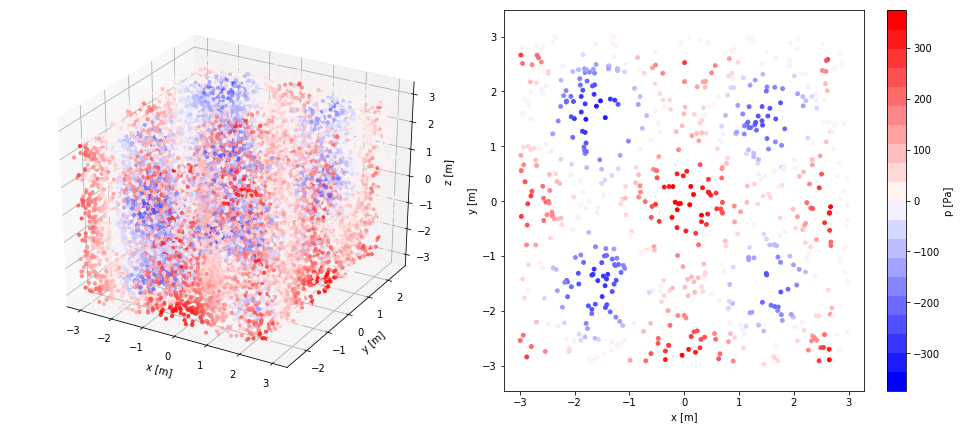

In [8]:
# create the figure
fig2 = plt.figure(figsize=(14,7))

# add a subplot for the 3D plot
ax3 = fig2.add_subplot(121, projection='3d')

ax3.scatter(X[:,0],X[:,1],X[:,2],s=10,c=pExtracted,cmap=cmap,vmin=pMin, vmax=pMax);

ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_zlabel('z [m]')

# add a subplot for the 2D plot
ax4 = fig2.add_subplot(122)

pExtracted_zPlane = pExtracted[np.abs(X[:,2])<zThresh]

ax4.scatter(X_zPlane[:,0],X_zPlane[:,1],s=15,c=pExtracted_zPlane,cmap=cmap,vmin=pMin,vmax=pMax)


ax4.set_xlabel('x [m]')
ax4.set_ylabel('y [m]')

# set the axes to equal because we're plotting physical data 
# so we don't want weird scale effects to fit a certain size
ax3.axis('equal')
ax4.axis('equal')

# initialize the colormap object
sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm2.set_array([])

plt.colorbar(sm2,label='p [Pa]')

# and set the spacing so the figure space is used effectively
plt.subplots_adjust(left=0.01,right=0.95,wspace=0.1)